Module importieren

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from fitter import Fitter
import numpy as np
from scipy import stats
import statsmodels.api as sm
from tabulate import tabulate

Daten laden und säubern

In [2]:
def open_csv_to_df(directory):
    df = pd.read_csv(directory)
    df = df.iloc[0:,:4]
    df.columns = ["Date", "Time", "Mass (kg)", "Velocity (m/s)"]
    #df_energy = pd.DataFrame()
    df.insert(4, "Energy", "")
    df.insert(5, "Date+Time", "")
    df.insert(6, "delta_time", "")
    for i in range(len(df)):
        df.iloc[i,4] = 0.5 * float(df.iloc[i,2]) * float(df.iloc[i,3]) ** 2 / 1000 #calculation of Energy
    df = df.sort_values(['Date', 'Time']).reset_index(drop=True)
    df = df.dropna()

    for i in range(len(df)):
        date_raw = df.iloc[i,:].Date +" " +df.iloc[i,:].Time
        date1 = datetime.strptime(date_raw, '%Y-%m-%d %H:%M')
        df.iloc[i,5] = date1

    for i in range(len(df)-1):
        date1 = df.iloc[i,5]
        date2 = df.iloc[i+1,5]
        delta_time = date2 - date1
        delta_time = (delta_time.days*24) + (delta_time.seconds//3600)
        df.iloc[i+1,6] = delta_time

    return df #this is the table with all stones combined

In [3]:
df1 = open_csv_to_df("./out_1.csv")
df2 = open_csv_to_df("./out_2.csv")

Todo: Sollte oben noch implementiert werden

In [ ]:
#Oberste Zeile löschen da Fitter Problem mit Null Values hat
df1= df1.iloc[1: , :]
df2= df2.iloc[1: , :]

#Datentyp ändern da Fitter Problem mit Datumobjekten hat
df1['deltatime'] = df1['deltatime'].astype('int')
df2['deltatime'] = df2['deltatime'].astype('int')

Funktion für Fitting von Verteilungen

In [ ]:
def fit_distribution(data):
    count = 0
    fitted_mass = Fitter(data)
    fitted_mass.fit()
    ks_summary = fitted_mass.summary()
    distributions = ks_summary.index.values
    print(ks_summary.iloc[:,-2:])
    fig, ax = plt.subplots(1,5,figsize=(25, 5))
    table = [['Distribution', 'Parameters']]


    for i in distributions:
        param = fitted_mass.fitted_param[i]
        table.append([i, param])
        dist_eval = eval('stats.' + i + '.rvs(*param, size = 1000)')
        sm.qqplot_2samples(data, dist_eval, xlabel = i.capitalize() + ' Distribution', ylabel = 'Sample Distribution', line = '45' ,ax = ax[count])
        count += 1
    plt.show()
    print(tabulate(table, headers = 'firstrow'))

Zone 1

In [ ]:
#fit_distribution(df1.Mass)

In [ ]:
#fit_distribution(df1.Velocity)

In [ ]:
#fit_distribution(df1.deltatime)

Zone 2

In [ ]:
#fit_distribution(df2.Mass)

In [ ]:
#fit_distribution(df1.Velocity)

In [ ]:
#fit_distribution(df1.deltatime)

Monte Carlo

In [24]:
def plot_verteilung(dataframe, x_val):
    sns.set_style("white")
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data = dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)

Zone 1

In [27]:
mass_sim = stats.norminvgauss.rvs(3.1212660746620413, 3.049636729092045, 34.65446329649014, 129.49172019279249, size = 100000)
df1_mass_sim = pd.DataFrame(mass_sim)

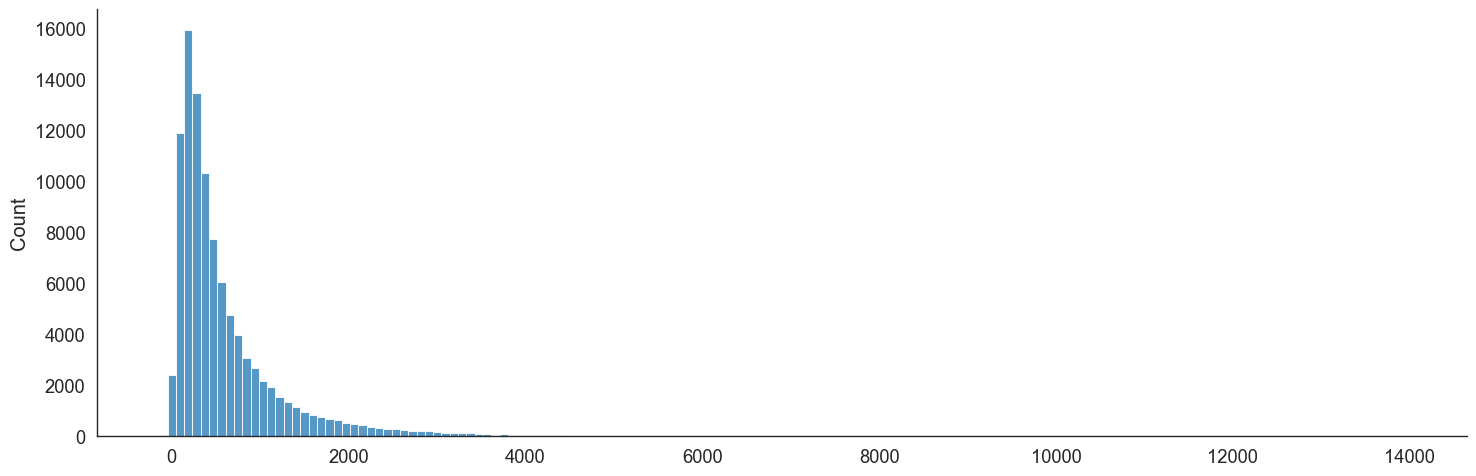

In [28]:
plot_verteilung(df1_mass_sim,mass_sim)